In [1]:
import numpy as np
import sys, os, pickle, torch

BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, BASE_DIR)
from config import device
from assistive_functions import WrapLogger
from experiments.robotsX.loss_functions import RobotsLoss
from controllers.SVGD_controller import SVGDCont
from experiments.robotsX.detect_collision import *
from experiments.robotsX.robots_sys import SystemRobots

random_seed = 5
random_state = np.random.RandomState(random_seed)
torch.manual_seed(random_seed)

logger = WrapLogger(None)

[INFO] running on CPU


/Users/mahrokh/anaconda3/envs/NOC/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ------ EXPERIMENT ------
col_av = True
obstacle = True
is_linear = False
fname = None     # set to None to be set automatically
# -----------------------
exp_name = 'robotsX'
exp_name += '_col_av' if col_av else ''
exp_name += '_obstacle' if obstacle else ''
exp_name += '_lin' if is_linear else '_nonlin'

# ------------ 1. Dataset ------------

num_rollouts = 30
t_end = 100
std_ini = 0.2
n_agents = 2
file_path = os.path.join(BASE_DIR, 'experiments', 'robotsX', 'saved_results')
filename_data = 'data_T'+str(t_end)+'_stdini'+str(std_ini)+'_agents'+str(n_agents)+'_RS'+str(random_seed)+'.pkl'
filename_data = os.path.join(file_path, filename_data)
if not os.path.isfile(filename_data):
    print(filename_data + " does not exists.")
    print("Need to generate data!")
assert os.path.isfile(filename_data)
filehandler = open(filename_data, 'rb')
data_saved = pickle.load(filehandler)
filehandler.close()
x0 = data_saved['x0'].to(device)
xbar = data_saved['xbar'].to(device)

train_data = data_saved['train_data_full'][:num_rollouts, :, :].to(device)
assert train_data.shape[0] == num_rollouts
test_data = data_saved['test_data'].to(device)

# ------------ 2. Parameters and hyperparameters ------------

# ------ 2.1. define the plant ------
k = 1.0
# Set initial values of variables in the loop
u_init = None   # all zero
x_init = None   # same as xbar
sys = SystemRobots(xbar, x_init=x_init, u_init=u_init, k=k, is_linear=is_linear)

# ------ 2.2. define the loss ------
Q = torch.kron(torch.eye(n_agents), torch.eye(4)).to(device)
alpha_u = 0.1/400 if col_av else 1/400
alpha_col = 100 if col_av else None
alpha_obst = 5e3 if obstacle else None
min_dist = 1.
loss_bound = 1
sat_bound = torch.matmul(torch.matmul(x0.reshape(1, -1), Q), x0.reshape(-1, 1))
sat_bound += 0 if alpha_col is None else alpha_col
sat_bound += 0 if alpha_obst is None else alpha_obst
sat_bound = sat_bound/20
logger.info('Loss saturates at: '+str(sat_bound))
bounded_loss_fn = RobotsLoss(
    Q=Q, alpha_u=alpha_u, xbar=xbar,
    loss_bound=loss_bound, sat_bound=sat_bound.to(device),
    alpha_col=alpha_col, alpha_obst=alpha_obst,
    min_dist=min_dist if col_av else None,
    n_agents=sys.n_agents if col_av else None,
)
original_loss_fn = RobotsLoss(
    Q=Q, alpha_u=alpha_u, xbar=xbar,
    loss_bound=None, sat_bound=None,
    alpha_col=alpha_col, alpha_obst=alpha_obst,
    min_dist=min_dist if col_av else None,
    n_agents=sys.n_agents if col_av else None,
)

# ------ 2.4. define the prior ------
prior_std = 7
prior_dict = {'type':'Gaussian'}
training_param_names = ['X', 'Y', 'B2', 'C2', 'D21', 'D22', 'D12']
for name in training_param_names:
    prior_dict[name+'_vec_loc'] = 0
    prior_dict[name+'_vec_scale'] = prior_std


Loss saturates at: tensor([[255.8000]])


In [3]:
num_particles = 10
if fname is not None:
    filename = fname+'_particles.pt'
else:
    filename = exp_name+'_SVGD_'+str(num_particles)+'particles_T'+str(t_end)+'_S'+str(num_rollouts)
    filename += '_stdini'+str(std_ini)+'_agents'+str(n_agents)+'_RS'+str(random_seed)+'.pt'
file_path = os.path.join(BASE_DIR, 'experiments', 'robotsX', 'saved_results', 'trained_models')
filename = os.path.join(file_path, filename)
res_dict = torch.load(filename)
logger.info('particles loaded.')

particles loaded.


In [4]:
particles = res_dict['particles']
num_particles = particles.shape[0]

# initialize SVGD controllers
svgd_cont = SVGDCont(
    sys, train_data, 
    lr=1e-2,                    # not important
    loss=bounded_loss_fn,
    prior_dict=prior_dict, 
    initialization_std=res_dict['initialization_std'],    
    num_particles=num_particles,
    initial_particles=None,     # not important
    kernel='RBF', bandwidth=None, random_seed=random_seed,
    batch_size=-1,              # not important 
    lambda_=None,               # not important 
    num_iter_fit=None,          # not important
    lr_decay=0.99, logger=logger, optimizer='Adam',
    n_xi=res_dict['n_xi'], l=res_dict['l'], 
    x_init=sys.x_init, u_init=sys.u_init, 
    controller_type='REN',
)

# set particles to the loaded ones
svgd_cont.particles = particles
    
# eval on train data
bounded_train_loss = svgd_cont.eval_rollouts(train_data)
original_train_loss = svgd_cont.eval_rollouts(train_data, loss_fn=original_loss_fn)
logger.info('Final results on the entire train data: Bounded train loss = {:.4f}, original train loss = {:.4f}'.format(
    bounded_train_loss, original_train_loss
))

# eval on test data
bounded_test_loss = svgd_cont.eval_rollouts(test_data)
original_test_loss = svgd_cont.eval_rollouts(test_data, loss_fn=original_loss_fn)
msg = 'True bounded test loss = {:.4f}, '.format(bounded_test_loss)
msg += 'true original test loss = {:.2f} '.format(original_test_loss)
msg += '(approximated using {:3.0f} test rollouts).'.format(test_data.shape[0])
logger.info(msg)


[INFO] initialized particles by sampling from the prior.
[INFO] initialized particles by sampling from the prior.
Final results on the entire train data: Bounded train loss = 0.0916, original train loss = 23.5032
True bounded test loss = 0.0980, true original test loss = 25.24 (approximated using 500 test rollouts).


In [5]:
train_loss_all_particles = svgd_cont.eval_rollouts(
    train_data, loss_fn=original_loss_fn, get_full_list=True
)
test_loss_all_particles = svgd_cont.eval_rollouts(
    test_data, loss_fn=original_loss_fn, get_full_list=True
)


In [6]:
import math
# Bootstrap data
repeats = 50
data_frac = 0.25
num_rollouts_bootstrap = math.floor(data_frac*num_rollouts)
data_boot_strap = [None]*repeats
for rep_num in range(repeats):
    data_boot_strap[rep_num] = np.zeros(
        (num_rollouts_bootstrap, train_data.shape[1], train_data.shape[-1])
    )
    inds = random_state.choice(
        range(num_rollouts), size=num_rollouts_bootstrap, replace=True
    )
    for row_num, ind in enumerate(inds):
        data_boot_strap[rep_num][row_num, :, :] = train_data[ind, :, :]


In [7]:
# eval on Bootstrap 
bootstrap_loss_all_particles = np.zeros((repeats, num_particles))
for rep_num in range(repeats):
    print(rep_num)
    bootstrap_loss_all_particles[rep_num, :] = svgd_cont.eval_rollouts(
        data_boot_strap[rep_num], loss_fn=original_loss_fn, get_full_list=True
    )


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


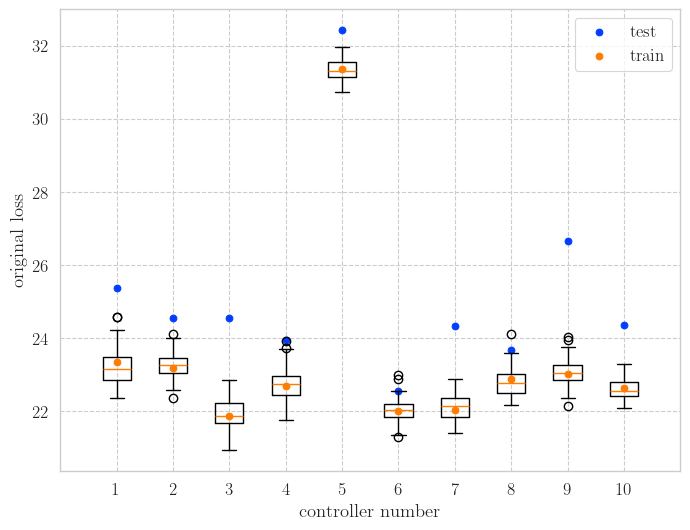

In [8]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# ------ format ------
plt.rcParams['text.usetex'] = True
sns.set_theme(
    context='paper', style='whitegrid', palette='bright', 
    font='sans-serif', font_scale=1.4, color_codes=True, rc=None, 
)
sns.set_style({'grid.linestyle': '--'})
mpl.rc('font', family='serif', serif='Times New Roman')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.boxplot(bootstrap_loss_all_particles)
ax.scatter(range(1, num_particles+1), test_loss_all_particles, label='test')
ax.scatter(range(1, num_particles+1), train_loss_all_particles, label='train')
ax.set_ylabel('original loss')
ax.set_xlabel('controller number')
ax.set_xlim(0, num_particles+1)
    
plt.legend()


In [9]:
test_loss_bounded = test_loss_all_particles
train_loss_bounded = train_loss_all_particles
boot_loss_bounded = bootstrap_loss_all_particles
num_sampled_controllers = num_particles

print('Controller Selection Strategies')
print('Bootstrap info: repeats = {:.0f}, samples fraction = {:1.2f}'.format(repeats, data_frac)+'\n')

msg = 'test loss of the controller minimizing '
print('average test loss of controllers: {:.4f}'.format(sum(test_loss_bounded)/num_sampled_controllers))

ind = train_loss_bounded.index(min(train_loss_bounded))
# print(ind)
print(msg + 'train loss: {:.4f}'.format(test_loss_bounded[ind]))

boot_loss_av = np.mean(boot_loss_bounded, axis=0)
ind = np.argmin(boot_loss_av)
# print(ind)
print(msg + 'mean Bootstrap loss: {:.4f}'.format(test_loss_bounded[ind]))

boot_loss_quan = np.quantile(boot_loss_bounded, q=3/4, axis=0)
ind = np.argmin(boot_loss_quan)
# print(ind)
print(msg + '3/4 quantile Bootstrap loss: {:.4f}'.format(test_loss_bounded[ind]))

boot_loss_std = np.std(boot_loss_bounded, axis=0)
ind = np.argmin(boot_loss_av + 1.95*boot_loss_std)
# print(ind)
print(msg + 'mean+1.95*std Bootstrap loss: {:.4f}'.format(test_loss_bounded[ind]))

ind = test_loss_bounded.index(min(test_loss_bounded))
# print(ind)
print(msg + 'test loss: {:.4f} (ideal)'.format(test_loss_bounded[ind]))


Controller Selection Strategies
Bootstrap info: repeats = 50, samples fraction = 0.25

average test loss of controllers: 25.2384
test loss of the controller minimizing train loss: 24.5382
test loss of the controller minimizing mean Bootstrap loss: 24.5382
test loss of the controller minimizing 3/4 quantile Bootstrap loss: 22.5658
test loss of the controller minimizing mean+1.95*std Bootstrap loss: 24.5382
test loss of the controller minimizing test loss: 22.5658 (ideal)
